In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp

In [14]:
DATAFOLDER = Path("..\\data")

In [15]:
def tweak_df(df):

    return (df
            .query("session == 's4'")
            )

df = pd.read_excel(DATAFOLDER / "metafile_ipp.xlsx", sheet_name="metafile Exp 1")
df = tweak_df(df)

In [16]:
def make_protein_pref_heatmap(casein_licks, malt_licks, bins):

    casein_hist = np.histogram(casein_licks, bins=bins)[0]
    malt_lickdata = np.histogram(malt_licks, bins=bins)[0]

    casein_cumsum = np.cumsum(casein_hist)
    malt_cumsum = np.cumsum(malt_lickdata)

    preference_cumsum = []
    for casbin, maltbin in zip(casein_cumsum, malt_cumsum):
        preference_cumsum.append(casbin/(maltbin+casbin))

    return preference_cumsum

def get_heatmap_data_from_row(row, **kwargs):
    filename = row.medfile
    # print(f"Processing {filename}")

    L, R = tp.medfilereader(DATAFOLDER / filename, vars_to_extract=["b", "e"], remove_var_header=True)

    if "malt" in row.bottleL and "cas" in row.bottleR:
        med_var_malt, med_var_casein = L, R
    elif "malt" in row.bottleR and "cas" in row.bottleL:
        med_var_malt, med_var_casein = R, L
    else:
        raise ValueError("Bottles not found")
    
    if "bins" in kwargs:
        bins = kwargs["bins"]
    else:
        bins = np.linspace(0,3600, 13)
    
    data = make_protein_pref_heatmap(med_var_casein, med_var_malt, bins)

    return data

get_heatmap_data_from_row(df.iloc[0], bins=np.linspace(0,3600, 61))

[0.0,
 0.20689655172413793,
 0.3915343915343915,
 0.351493848857645,
 0.3115264797507788,
 0.4274611398963731,
 0.36585365853658536,
 0.36585365853658536,
 0.3679558011049724,
 0.32205029013539654,
 0.32811140121845084,
 0.369281045751634,
 0.3192090395480226,
 0.2749391727493917,
 0.2749391727493917,
 0.2749391727493917,
 0.2749391727493917,
 0.27801332525741973,
 0.27801332525741973,
 0.27801332525741973,
 0.2512315270935961,
 0.2512315270935961,
 0.2512315270935961,
 0.23193532086912583,
 0.21961722488038277,
 0.21961722488038277,
 0.21961722488038277,
 0.21961722488038277,
 0.2428040854224698,
 0.33833671399594323,
 0.4195729537366548,
 0.4694209499024073,
 0.467444120505345,
 0.4737516005121639,
 0.464576802507837,
 0.464576802507837,
 0.464576802507837,
 0.46326977180368867,
 0.46326977180368867,
 0.5005817335660268,
 0.5393077542259189,
 0.5583847736625515,
 0.5583847736625515,
 0.5531210191082803,
 0.5489254108723135,
 0.5559355153883733,
 0.587568058076225,
 0.6122840690978887

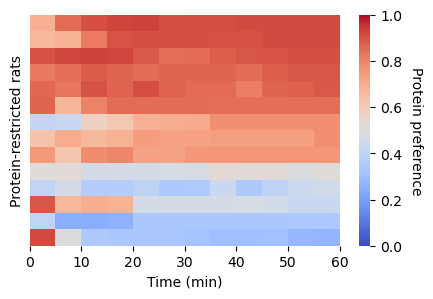

In [17]:
def sort_by_last_value(data):
    data = np.array(data)
    return data[np.argsort(data[:, -1])]

bins=np.linspace(0,3600, 13)

PR_data = []
for row in df.query("dietgroup == 'PR'").iterrows():
    data = get_heatmap_data_from_row(row[1], bins=bins)
    PR_data.append(data)

NR_data = []
for row in df.query("dietgroup == 'NR'").iterrows():
    data = get_heatmap_data_from_row(row[1], bins=bins)
    NR_data.append(data)

PR_data_to_plot = sort_by_last_value(PR_data)
NR_data_to_plot = sort_by_last_value(NR_data)

f, ax = plt.subplots(figsize=(5,3))
sns.heatmap(PR_data_to_plot, ax=ax,
            cmap="coolwarm",
            vmin=0, vmax=1,
            )

# Rotate the colorbar label
cbar = ax.collections[0].colorbar
# cbar.set_label('Protein\npreference', rotation=0, labelpad=35)
cbar.set_label('Protein preference', rotation=270, labelpad=15)

ax.invert_yaxis()
ax.set_yticks([])
ax.set_ylabel("Protein-restricted rats")

ticks = np.linspace(0, PR_data_to_plot.shape[1], 7)

ax.set_xticks(ticks,
              labels=[0, 10, 20, 30, 40, 50, 60],
              rotation=0)
ax.set_xlabel("Time (min)")

f.savefig(Path("..\\figures") / "PR_heatmap.png", dpi=300)

In [18]:
def bky_correction(pvals, alpha=0.05):
    """
    Perform the Benjamini, Krieger, and Yekutieli (BKY) FDR correction.
    
    Parameters:
    pvals (list or np.array): Array of p-values.
    alpha (float): Significance level.
    
    Returns:
    np.array: Array of boolean values indicating which hypotheses to reject.
    """
    pvals = np.array(pvals)
    m = len(pvals)
    sorted_indices = np.argsort(pvals)
    sorted_pvals = pvals[sorted_indices]
    
    # Calculate the critical values
    critical_values = np.arange(1, m + 1) * alpha / (m * (1 + alpha / (m + 1)))
    
    print(critical_values)
    
    # Find the largest k such that p(k) <= critical_value(k)
    reject = np.zeros(m, dtype=bool)
    for k in range(m - 1, -1, -1):
        if sorted_pvals[k] <= critical_values[k]:
            reject[:k + 1] = True
            break
    
    # Reorder the reject array to match the original p-values order
    reject = reject[np.argsort(sorted_indices)]
    return reject

reject = bky_correction(p, alpha=0.05)

[0.0041507  0.0083014  0.01245211 0.01660281 0.02075351 0.02490421
 0.02905492 0.03320562 0.03735632 0.04150702 0.04565773 0.04980843]


In [19]:
from scipy.stats import ttest_1samp
t, p = ttest_1samp(PR_data_to_plot, 0.5, axis=0)

# Apply FDR correction using the Benjamini, Krieger, and Yekutieli method
reject = bky_correction(p, alpha=0.05)


[0.0041507  0.0083014  0.01245211 0.01660281 0.02075351 0.02490421
 0.02905492 0.03320562 0.03735632 0.04150702 0.04565773 0.04980843]


In [21]:
p

array([0.00256825, 0.01801203, 0.01800265, 0.01287647, 0.01277332,
       0.01638537, 0.01489819, 0.00800892, 0.01317507, 0.00962479,
       0.01169576, 0.00999351])

In [20]:
reject

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

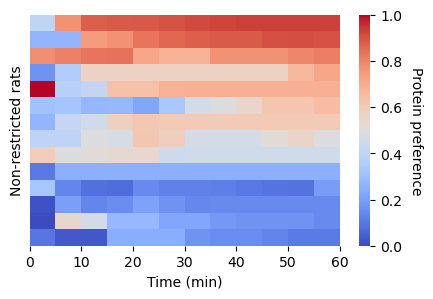

In [22]:
f, ax = plt.subplots(figsize=(5,3))
sns.heatmap(NR_data_to_plot, ax=ax, cmap="coolwarm", vmin=0, vmax=1)
ax.invert_yaxis()
ax.set_yticks([])
ax.set_ylabel("Non-restricted rats")

# Rotate the colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label('Protein preference', rotation=270, labelpad=15)

ax.set_xticks(ticks,
              labels=[0, 10, 20, 30, 40, 50, 60],
              rotation=0)
ax.set_xlabel("Time (min)")

f.savefig(Path("..\\figures") / "NR_heatmap.png", dpi=300)

In [23]:
from scipy.stats import ttest_1samp
t, p = ttest_1samp(NR_data_to_plot, 0.5, axis=0)

reject = bky_correction(p, alpha=0.05)

[0.0041507  0.0083014  0.01245211 0.01660281 0.02075351 0.02490421
 0.02905492 0.03320562 0.03735632 0.04150702 0.04565773 0.04980843]


In [70]:
p

array([0.05327254, 0.06852194, 0.39780452, 0.65506768, 0.80923556,
       0.73974272, 0.70692184, 0.77806111, 0.79805319, 0.88786941,
       0.98133226, 0.93364709])

In [24]:
reject

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [81]:
df = pd.read_excel(DATAFOLDER / "metafile_ipp.xlsx", sheet_name="metafile Exp 2")
df = tweak_df(df)

Text(0.5, 3.722222222222216, 'Time (min)')

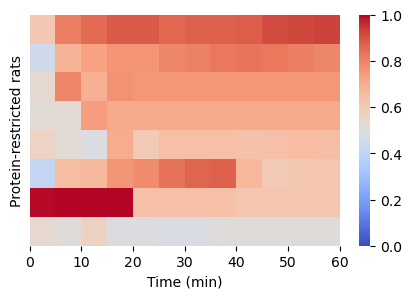

In [82]:
PR_data = []
for row in df.query("dietgroup == 'PR'").iterrows():
    data = get_heatmap_data_from_row(row[1], bins=bins)
    PR_data.append(data)

NR_data = []
for row in df.query("dietgroup == 'NR'").iterrows():
    data = get_heatmap_data_from_row(row[1], bins=bins)
    NR_data.append(data)

PR_data_to_plot = sort_by_last_value(PR_data)
NR_data_to_plot = sort_by_last_value(NR_data)

f, ax = plt.subplots(figsize=(5,3))
sns.heatmap(PR_data_to_plot, ax=ax, cmap="coolwarm", vmin=0, vmax=1)
ax.invert_yaxis()
ax.set_yticks([])
ax.set_ylabel("Protein-restricted rats")

ticks = np.linspace(0, PR_data_to_plot.shape[1], 7)

ax.set_xticks(ticks,
              labels=[0, 10, 20, 30, 40, 50, 60],
              rotation=0)
ax.set_xlabel("Time (min)")

In [86]:
from scipy.stats import ttest_1samp
t, p = ttest_1samp(PR_data_to_plot, 0.5, axis=0)

reject = bky_correction(p, alpha=0.05)

In [87]:
reject

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

Text(0.5, 3.722222222222216, 'Time (min)')

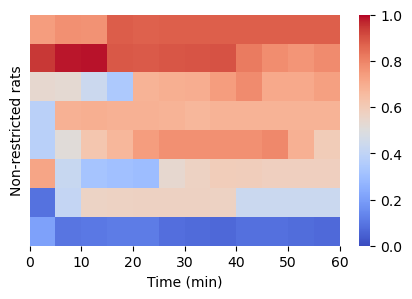

In [83]:
f, ax = plt.subplots(figsize=(5,3))
sns.heatmap(NR_data_to_plot, ax=ax, cmap="coolwarm", vmin=0, vmax=1)
ax.invert_yaxis()
ax.set_yticks([])
ax.set_ylabel("Non-restricted rats")

ax.set_xticks(ticks,
              labels=[0, 10, 20, 30, 40, 50, 60],
              rotation=0)
ax.set_xlabel("Time (min)")

In [84]:
from scipy.stats import ttest_1samp
t, p = ttest_1samp(NR_data_to_plot, 0.5, axis=0)

reject = bky_correction(p, alpha=0.05)

In [85]:
reject

array([False, False, False, False, False, False, False, False, False,
       False, False, False])